# Lab exercise - wave radiation and diffraction
In this notebook we will consider experiments in the wave laboratory, where a ship section will be tested. Two hydrodynamic problems are considered: 
* First, the heave radiation problem will be studied, where the model is forced to perform harmonic oscillations in heave in calm water. The objective of this test is to obtain the hydrodynamic radiation forces (added mass and damping). 
* Second, the diffraction problem will be considered, where the model is fixed and exposed to regular beam sea waves to determine wave excitation force in heave (sum of Froude-Kriloff and diffraction forces).

## Preparations
Preparations prior to lab visit:
When model experiments are planned, it is very important to be well prepared before going to the lab. One should have a clear view of the research questions - what do you seek with the experiments?, what can go wrong?, what do you need to be aware of (precautions)?

## Model and setup
The model is a mid-ship cross-section of a conventional displacement vessel with rounded bilges.

|Parameter   |	Symbol|	Value|	Unit|
|------------|--------|------|------|
|Beam        |	B     |	0.50 |	m   |
|Draft       |	T     |	0.125|	m   |
|Length      |	L     |	0.59 |	m   |
|Bilge radius|	R     |	0.025|	m   |
|Mass        |  M     | 36   | kg   |

<div>
<img src="Figures/model_v2.png" width="300">
</div>

The model is mounted to a vertical actuator on the tank carriage. The model is located in the middle of the tank, at a distance $x_{model}=6.76$ m from the wavemaker. Further, the locations of the wave probes relative to the wavemaker are

|Wave probe | Position |Unit|
|-----------|----------|----|
|WP1        |	3.44   | m  |
|WP2        |	5.89   | m  |

<div>
<img src="Figures/lab_setup.png" width="700">
</div>

The water-depth in the wavetank should be around 1.0 m, but should be checked before measurements are made. 

In [3]:
import numpy as np

# Model particulars:
rho=1000. # [kg/m^3]
g = 9.81 # [m/s^2]
L = 0.59 # [m]
B = 0.50 # [m]
d = 0.15 # [m]
r = 0.025 # [m]
M = 37.0  # [kg]
Mrigg = 10.3 # [kg]
Depl = rho*L*(B*(d-r)+(B-2*r)*r+np.pi*r**2/2.) # [kg]

# Model position from wavemaker
modelpos = 7. # [m]

# Water depth
h = 1.0 # [m]

## Post processing
We start all post-processing of data by loading the data-set and inspecting the data by plotting the raw measurements as time-series. Here we will make use of the python package pandas when working with time-series.

In [4]:

import matplotlib.pyplot as plt
import pandas as pd
import postprocessing as pp

datapath = "../shared/Labdata"

radiationtestfile = "Gruppe6_2060_rad.npz"  # Enter the name of your data-file here..
diffractiontestfile = "Gruppe6_2060_diff.npz"  # Enter the name of your data-file here..

# Import data as pandas DataFrame
df = pp.importDataFrame(datapath, radiationtestfile)

# We take a look at the first rows of data. Each measurement signal is stored column-wise
print(df.head())

   Time  1 - default sample rate  6047 Position  WM_Position  FX_20194  \
0                          0.000       0.000005    -0.000004 -0.001400   
1                          0.005       0.000005    -0.000004 -0.000621   
2                          0.010       0.000004    -0.000004  0.000033   
3                          0.015       0.000003    -0.000004  0.000177   
4                          0.020       0.000003    -0.000004  0.000354   

   FZ_20638  ACC_20497_X  ACC_20642_Z       WP1       WP2  FX_Calculated  \
0 -0.003581     0.003013    -0.006351  0.000024 -0.000013       0.236527   
1 -0.002594     0.000198    -0.002366  0.000023 -0.000021       0.106362   
2 -0.001488    -0.001584     0.000560  0.000024 -0.000014      -0.003328   
3 -0.000606    -0.000572     0.000374  0.000029 -0.000004      -0.028366   
4  0.000267    -0.000066     0.000249  0.000022  0.000003      -0.058899   

   FZ_Calculated  
0       0.565091  
1       0.409359  
2       0.234851  
3       0.095753  
4  

Looking at the dataframe above, we see that it might be convenient to rename the columns with simpler names. Further, we are informed that the actuator signal "Pos_Rig" is the stroke of the actuator defined positive downwards. We will reverse the sign to consider the vertical (heave) motion of the model, with positive direction upwards.

In [5]:
# Let's rename the columns using the new names below:
columnnames=df.keys()
newnames=['Time', 'eta3', 'WM_pos', 'Fsig2', 'Fsig3', 'acc2', 'acc3', 'WP1', 'WP2', 'F2', 'F3']
column_names = dict(zip(df.keys(), newnames))  # This creates a dictionary with {oldname: newname}
df.rename(columns=column_names, inplace=True)

# Reverse the sign to convert actuator stroke to heave motion.
df['eta3'] = -df['eta3']

#Set the column named "Time" as the index. This makes it possible to select data based on time values, instead of using row indices
df.set_index("Time", inplace=True)

# Now let us have a look at the data:
print(df.head())

           eta3    WM_pos     Fsig2     Fsig3      acc2      acc3       WP1  \
Time                                                                          
0.000 -0.000005 -0.000004 -0.001400 -0.003581  0.003013 -0.006351  0.000024   
0.005 -0.000005 -0.000004 -0.000621 -0.002594  0.000198 -0.002366  0.000023   
0.010 -0.000004 -0.000004  0.000033 -0.001488 -0.001584  0.000560  0.000024   
0.015 -0.000003 -0.000004  0.000177 -0.000606 -0.000572  0.000374  0.000029   
0.020 -0.000003 -0.000004  0.000354  0.000267 -0.000066  0.000249  0.000022   

            WP2        F2        F3  
Time                                 
0.000 -0.000013  0.236527  0.565091  
0.005 -0.000021  0.106362  0.409359  
0.010 -0.000014 -0.003328  0.234851  
0.015 -0.000004 -0.028366  0.095753  
0.020  0.000003 -0.058899 -0.042023  


Text(0.5, 0, 'Time [s]')

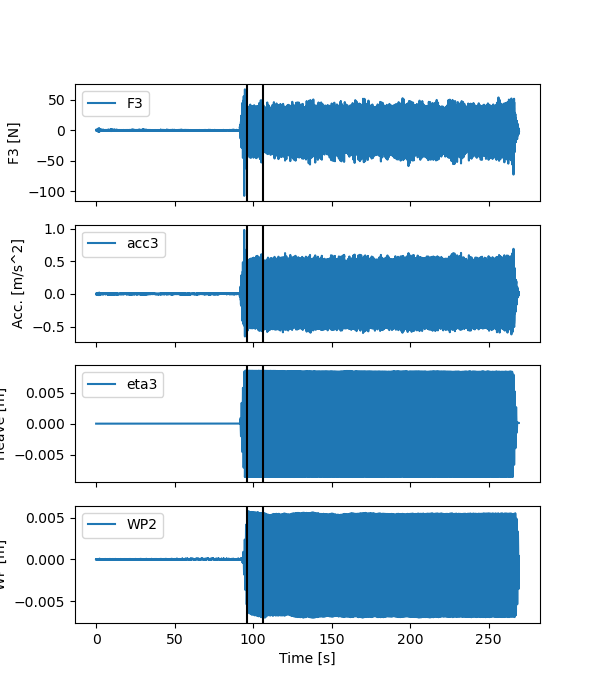

In [6]:
# Uncomment the line below if you will activate interactive plotting
%matplotlib widget
# Uncomment the line below if you will go back to in-line plotting
#%matplotlib inline 

#Looking at the time column, we see that data are sampled every 0.005 s.
#Sampling frequency
dt = 0.005 # [s] time between samples
fs = 1/dt # [Hz] sampling frequency

tstart = 96 # Define start of time-window for estimation of steady state values
tstop = 106  # Define end of time-window


# To get an overview of our measurements, the first thing to do is to plot the time-series: 
fig, ax = plt.subplots(4, 1, figsize=(6, 7), sharex=True) # Create fig handle with four axis
df.plot(ax=ax[0], y='F3') # the data is plotted against x="Time" which we have set to be the index
ax[0].axvline(tstart, color='k') # add vertical line to indicate start time-window
ax[0].axvline(tstop, color='k') # add vertical line to indicate stop time-window
ax[0].set_ylabel('F3 [N]')

df.plot(ax=ax[1], y='acc3')
ax[1].axvline(tstart, color='k') # add vertical line to indicate start time-window
ax[1].axvline(tstop, color='k') # add vertical line to indicate stop time-window
ax[1].set_ylabel('Acc. [m/s^2]')

df.plot(ax=ax[2], y='eta3')
ax[2].axvline(tstart, color='k') # add vertical line to indicate start time-window
ax[2].axvline(tstop, color='k') # add vertical line to indicate stop time-window
ax[2].set_ylabel('Heave [m]')

df.plot(ax=ax[3], y='WP2')
ax[3].axvline(tstart, color='k') # add vertical line to indicate start time-window
ax[3].axvline(tstop, color='k') # add vertical line to indicate stop time-window
ax[3].set_ylabel('WP [m]')
ax[3].set_xlabel('Time [s]')


We see from the figure above that the raw signals contain some noise, in particular the acceleration and force measurements. A common procedure is to filter the data with a *low-pass filter*. This means that we filter away all high frequency components above a given threshold (cut-frequency) and let the low frequency components pass the filter. When defining the cut frequency, we must be sure that we don't remove "physical" frequencies associated with the waves. We will use $f_{cut}=5$Hz in the following.

In [7]:
# Let's filter the data using a low-pass filter to remove high frequency noise
fcut=2 # [Hz] cut frequency
df_filtered = pp.filterDataFrame(df, fcut, fs)

Text(0.5, 0, 'Time [s]')

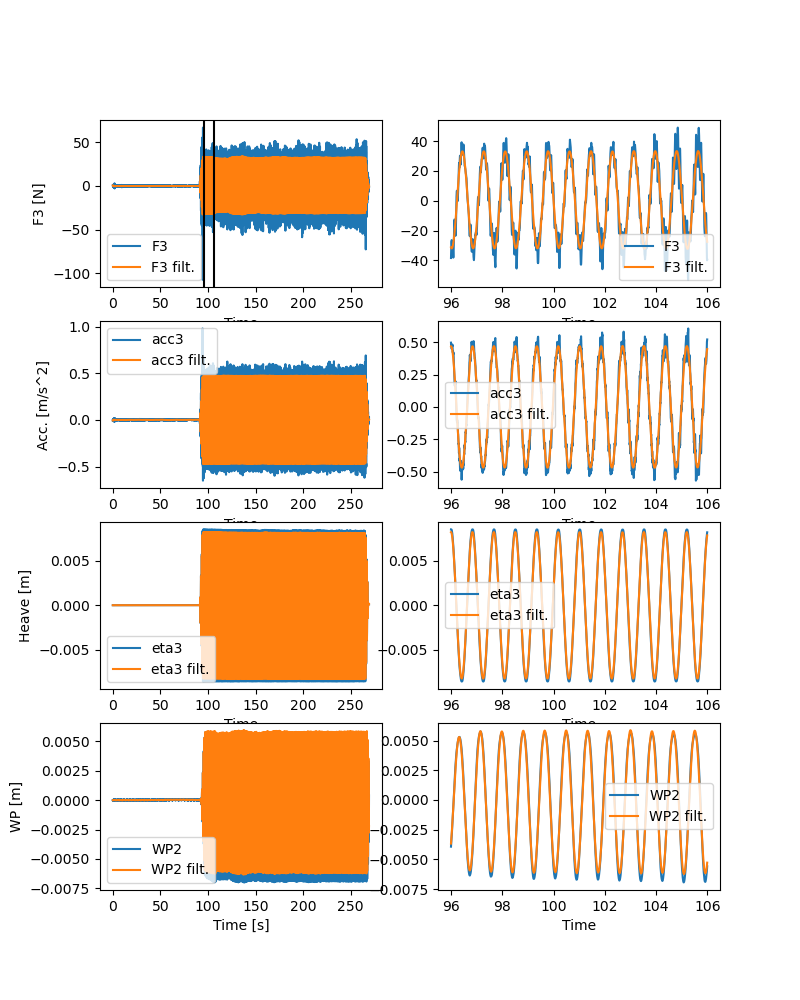

In [8]:
# Uncomment line below if you will activate interactive plotting
%matplotlib widget 
#%matplotlib inline # Uncomment this line if you will go back to in-line plotting

# We will also have a closed look at a given window of the time-series, e.g. between tstart and tstop.
df1 = df.loc[tstart:tstop]
df1_filt = df_filtered.loc[tstart:tstop]

# Create figure handle with four rows and two columns (eight plots)
gs_kw = dict(width_ratios=[2, 1], height_ratios=[1, 1])
fig, ax = plt.subplots(4, 2, figsize=(8, 10))

# Plot force, left
df.plot(ax=ax[0,0], y='F3')
df_filtered.plot(ax=ax[0,0], y='F3', label='F3 filt.')
ax[0,0].axvline(tstart, color='k') # add vertical line to indicate start time-window
ax[0,0].axvline(tstop, color='k') # add vertical line to indicate stop time-window
ax[0,0].set_ylabel('F3 [N]')

# Force zoomed, right
df1.plot(ax=ax[0,1], y='F3')
df1_filt.plot(ax=ax[0,1], y='F3', label='F3 filt.')

# Plot acceleration, left
df.plot(ax=ax[1,0], y='acc3')
df_filtered.plot(ax=ax[1,0], y='acc3', label='acc3 filt.')
ax[1,0].set_ylabel('Acc. [m/s^2]')

# Acc. zoomed, right
df1.plot(ax=ax[1,1], y='acc3')
df1_filt.plot(ax=ax[1,1], y='acc3', label='acc3 filt.')

# Plot heave motion, left
df.plot(ax=ax[2,0], y='eta3')
df_filtered.plot(ax=ax[2,0], y='eta3', label='eta3 filt.')
ax[2,0].set_ylabel('Heave [m]')

# Heave zoomed, right
df1.plot(ax=ax[2,1], y='eta3')
df1_filt.plot(ax=ax[2,1], y='eta3', label='eta3 filt.')

# Plot wave elevation, left
df.plot(ax=ax[3,0], y='WP2')
df_filtered.plot(ax=ax[3,0], y='WP2', label='WP2 filt.')
ax[3,0].set_ylabel('WP [m]')

# Wave zoomed, right
df1.plot(ax=ax[3,1], y='WP2')
df1_filt.plot(ax=ax[3,1], y='WP2', label='WP2 filt.')

# Add x-axis label to last row
ax[3,0].set_xlabel('Time [s]')


We need to know when wave reflections are contaminating our measurements. To estimate the time before wave reflections, we need to know the group velocity, as the wave front propagates with the group velocity. Implement in below code-block:
* Expression for group velocity for finite water depth
* Time taken for a wave front to propagate from the model to the wavemaker and back

In [9]:
import airywavelib as aw

def calcGroupVel(T, h):
    '''
    Compute group velocity
    param [in] T - [s] wave period
    param [in] h - [m] water depth
    
    return Cg [m/s] Group velocity
    '''
    # Compute wave-number:
    omega = 2*np.pi/T
    k = aw.findWaveNumber(omega, h) 

    Cg = 0.5*omega/k*(1+2*k*h/np.sinh(2*k*h))

    return Cg
    

def getReflectionTime(T, h, xpos):
    '''
    Compute the time before waves diffracted from the model reach back to the model
    param [in] T - [s] wave period
    param [in] h - [m] water depth
    param [in] xpos - [m] model distance from wavemaker
    
    return tr [s] time before reflections reach model
    '''
    Cg = calcGroupVel(T, h)
    tr = 2*xpos/Cg
    
    return tr

In [10]:

# Get oscillation period from the mesaurements
Tper = pp.getZeroUpcrossingPeriod(df1.index.values, df1_filt['eta3'].values)
print("Wave period: T={:.3f} s".format(Tper))
omega = 2*np.pi/Tper
print("Wave frequency: omega={:.3f} s".format(omega))

# Corresponding wavenumber
k = aw.findWaveNumber(omega, waterDepth=h)

# Group velocity for finite water depth
Cg = calcGroupVel(Tper, h)

# Time before wave reflection reach model:
reflectiontime = getReflectionTime(Tper, h, modelpos)

print("Group velocity: Cg={:.3f} m/s".format(Cg))
print("Time before wave reflection: {:.2f} s".format(reflectiontime))


Wave period: T=0.836 s
Wave frequency: omega=7.514 s
Group velocity: Cg=0.653 m/s
Time before wave reflection: 21.44 s


We want to use the measurements to obtain derived quantities, like the inertia force and restoring force. The inertia force in the vertical direction is found as $I_3=M\ddot{\eta}_3$. Let us compute the inertia force.

After ensuring that we don't have wave reflections in our selected time-window, we can extract the hydrodynamic forces from the measured force applied on the model from the actuator.

Text(0, 0.5, 'Force [N]')

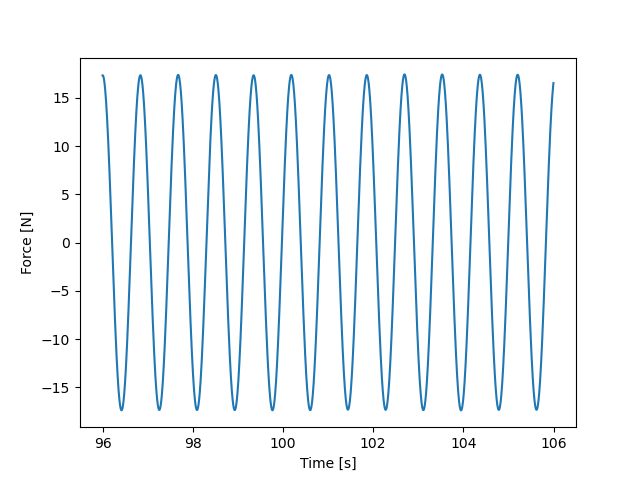

In [11]:
# Inertia force (mass times acceleration):
F_inertia = M*df1_filt['acc3'].values

plt.figure()
plt.plot(df1_filt.index.values, F_inertia)
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')

In [12]:
# Extract the hydrodynamic force

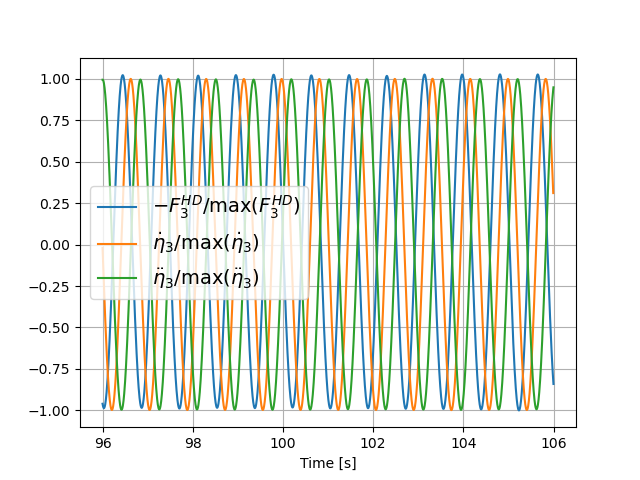

In [13]:
C33 = rho*g*L*B # Restoring coefficient (water-plane stiffness)

# Hydrodynamic force
Fhd = -df1_filt['F3'].values + (M+Mrigg)*df1_filt['acc3'].values - C33*df1_filt['eta3'].values

# Velocity in heave deduced from differentiation of the heave motion
eta3dot = np.diff(df1_filt['eta3'].values)/dt

# Let us have a look at the phase between -Fhd and the acceleration
plt.figure()
plt.plot(df1_filt.index.values, -Fhd/np.max(Fhd), label=r"$-F_3^{HD}/\max(F_3^{HD})$")
plt.plot(df1_filt.index.values[:-1], eta3dot/np.max(eta3dot), label=r'$\dot{\eta}_3/\max(\dot{\eta}_3)$')
plt.plot(df1_filt.index.values, df1_filt['acc3'].values/np.max(df1_filt['acc3'].values), label=r'$\ddot{\eta}_3/\max(\ddot{\eta}_3)$')
plt.xlabel('Time [s]')
plt.grid('on')
plt.legend(fontsize=14)

We observe that the peaks of the negative hydrodynamic force $(-F_3^{hd})$ occur between peaks of acceleration and peaks of velocity. Meaning, the force has a phase angle relative to acceleration and relative to velocity. We introduce the negative sign, as the force is in oposite direction to the acceleration or velocity (it is a reaction force). As acceleration and velocity are orthogonal ($90^{\circ}$ out of phase), we can decompose the force into one component in phase with velocity and one component in phase with acceleration. Mathematically, we write:
$$F_{3}^{hd}=-A_{33}\ddot{\eta}_3-B_{33}\dot{\eta}_3$$
Next, we model the heave motion as $\eta_3=\eta_{3a}\cos(\omega t+\delta)$, where $\delta$ is a phase angle to be determined from the measured heave motion.

Oscillation period: 0.836s
eta3a=0.008 m
delta=-0.055 rad


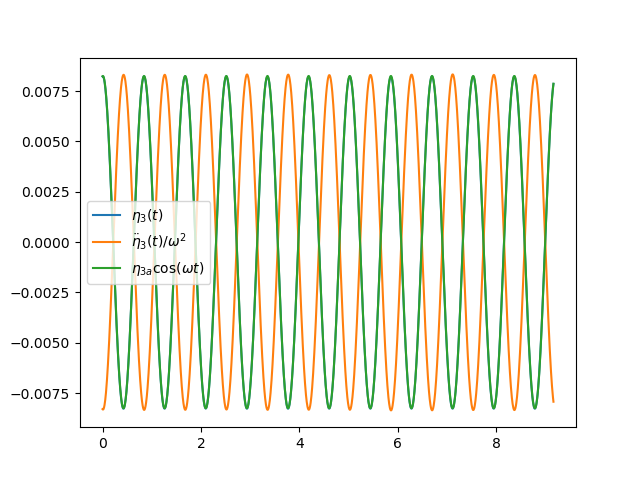

In [16]:
#locate zero upcrossings of measured heave
iups = np.ravel(np.argwhere(np.diff(np.sign(df1_filt['eta3'].values)) > 0))

nPer = len(iups)-1 # Number of complete oscillation periods

# Simple estimation of heave amplitude from first oscillation eta3a=0.5*(max(eta3)-min(eta3))
eta3a = 0.5*(np.max(df1_filt['eta3'].values[iups[0]:iups[1]])-np.min(df1_filt['eta3'].values[iups[0]:iups[1]]))

# We redefine the time vector, such that t=0 is when the actuator position is on top (eta_3=eta_3A*cos(omega*t))
tvec0 = df1_filt.index
Tper = np.mean(np.diff(tvec0[iups]))
idt = Tper/4.*fs
i1 = iups[0]+int(idt)
i2 = iups[-1]+int(idt)
tvec1 = df1_filt.index[i1:i2] - tvec0[i1]

print("Oscillation period: {:.3f}s".format(Tper))

# Phase angle
delta = pp.getPhaseDifference(tvec1, df1_filt['eta3'].iloc[i1:i2], np.cos(omega*tvec1)) * omega

print("eta3a={:.3f} m".format(eta3a))
print("delta={:.3f} rad".format(delta))


# Verify phase angle - acceleration a_3 should be 180 deg. out of phase relative to motion eta_3
fig0, ax0 = plt.subplots(1, 1)
ax0.plot(tvec1, df1_filt['eta3'].iloc[i1:i2], label=r'$\eta_3(t)$')
ax0.plot(tvec1, -df1_filt['acc3'].iloc[i1:i2]/omega**2, label=r'$\ddot{\eta}_3(t)/\omega^2$')
ax0.plot(tvec1, eta3a*np.cos(omega*tvec1+delta), label=r'$\eta_{3a}\cos(\omega t)$')
ax0.legend()
#ax0.axvline()


From the above figure we see that the modelled heave motion with the obtained phase angle and amplitude is consistent with measured heave motion and measured heave acceleration. Now we can decompose the hydrodynamic force into added mass and damping utilizing *orthogonal properties* of sine and cosine (the functions $f(x)$ and $g(x)$ are defined to be orthogonal if the integral of their product over some interval is zero, i.e. if $\int f(x)g(x)\mathrm{d}x=0$.), making the substitution 
$$\dot{\eta}_3(t)=-\omega\eta_{3a}\sin(\omega t)$$
$$\ddot{\eta}_3(t)=-\omega^2\eta_{3a}\cos(\omega t)$$
(here we have omitted the phase angle $\delta$ for brevity). Added mass is then found by multiplication of the hydrodynamic force by $\cos(\omega t)$ and integrate over $n$ oscillation periods:
$$\int_0^{nT}F_3^{hd}\cos(\omega t)\mathrm{d}t=-A_{33}\int_0^{nT}(-\omega^2 \eta_{3a}\cos(\omega t))\cos(\omega t)\mathrm{d}t - B_{33}\int_0^{nT}(-\omega \eta_{3a}\sin(\omega t))\cos(\omega t)\mathrm{d}t$$
As the force component proportional to $\sin(\omega t)$ becomes zero by integration due to ortogonality, this yields
$$A_{33}=\frac{\int_0^{nT}F_3^{hd}\cos(\omega t)\mathrm{d}t}{\omega\eta_{3a}n\pi}$$
Similarly, damping is found by multiplying the hydrodynamic force by $\sin(\omega t)$, and we obtain
$$\int_0^{nT}F_3^{hd}\sin(\omega t)\mathrm{d}t=-A_{33}\int_0^{nT}(-\omega^2 \eta_{3a}\sin(\omega t))\cos(\omega t)\mathrm{d}t - B_{33}\int_0^{nT}(-\omega \eta_{3a}\sin(\omega t))\sin(\omega t)\mathrm{d}t$$
which leads to
$$B_{33}=\frac{\int_0^{nT}F_3^{hd}\sin(\omega t)\mathrm{d}t}{\eta_{3a}n\pi}$$

In [20]:
import scipy.integrate as si  # We will use the trapeziodal method for numerical integration

fs = 200
idelta = int(np.round(delta/omega)*fs)

# We reset the time to start
tvec2 = tvec1 - tvec1[iups[0]] + (tvec1[iups[1]]-tvec1[iups[0]])/4.

# Compute added mass and damping coefficients
A33 = si.trapz(Fhd[i1:i2] * np.cos(omega*tvec1), x=tvec1) / (omega*eta3a*nPer*np.pi)
B33 = si.trapz(Fhd[i1:i2] * np.sin(omega*tvec1), x=tvec1) / (eta3a*nPer*np.pi)
print("omega={:.3f} rad/s, A33={:.3f} kg, B33={:.3f} kg/s".format(omega, A33, B33))
print("omega_hat={:.3f} [-], Ca33={:.3f} [-], Cb33={:.3f} [-]".format(omega*np.sqrt(B/(2*g)), A33/M, B33/(M*np.sqrt((2*g)/B))))
#print("omega*delta t: {} [rad]".format(omega*0.25))

omega=7.514 rad/s, A33=63.835 kg, B33=134.773 kg/s
omega_hat=1.199 [-], Ca33=1.725 [-], Cb33=0.581 [-]


Text(0, 0.5, '$b_{33}^{2D}$')

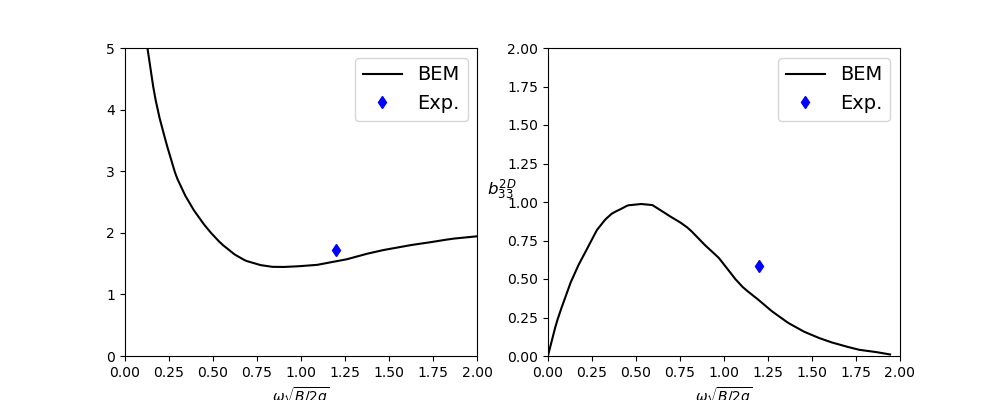

In [21]:
# Import numerical data for comparison (digitized from figure 3-20 in the compendium)
a33data = pd.read_csv("Data/Addedmass_2d_bem.csv", dtype=float, decimal=',')
b33data = pd.read_csv("Data/Damping_2d_bem.csv", dtype=float, decimal=',')

# Verify phase angle
fig2, ax2 = plt.subplots(1, 2, figsize=(10,4))
a33data.plot(ax=ax2[0], x='x', y='a33_Bd2d_2_bem', color='k', label='BEM')
ax2[0].plot(omega*np.sqrt(B/(2*g)), A33/M, 'bd', label='Exp.')
ax2[0].set_ylim(ymin=0., ymax=5.)
ax2[0].set_xlim(xmin=0., xmax=2.)
ax2[0].set_xlabel(r"$\omega\sqrt{B/2g}$")
ax2[1].set_ylabel(r"$a_{33}^{2D}$", rotation=0, fontsize=12)
ax2[0].legend(fontsize=14)

b33data.plot(ax=ax2[1], x='x', y='b33_Bd2d_2_bem', color='k', label='BEM')
ax2[1].plot(omega*np.sqrt(B/(2*g)), B33/(M*np.sqrt((2*g)/B)), 'bd', label='Exp.')
ax2[1].set_ylim(ymin=0, ymax=2.0)
ax2[1].set_xlim(xmin=0, xmax=2.0)
ax2[1].legend(fontsize=14)
ax2[1].set_xlabel(r"$\omega\sqrt{B/2g}$")
ax2[1].set_ylabel(r"$b_{33}^{2D}$", rotation=0, fontsize=12)



## Diffraction problem
Next we consider the diffraction problem, where the model is clamped (restrained from moving) while exposed to beam sea regular waves.

In [22]:
# Import data from diffraction test as pandas DataFrame
df2 = pp.importDataFrame(datapath, diffractiontestfile) 

# We take a look at the first rows of data. Each measurement signal is stored column-wise
print(df2.head()) # The data below is not from diffraction test...

# Rename columns with previously defined names:
df2.rename(columns=column_names, inplace=True)
df2.set_index("Time", inplace=True)

# Filter data
df2_filt = pp.filterDataFrame(df2, fcut, fs)

   Time  1 - default sample rate  6047 Position  WM_Position  FX_20194  \
0                          0.000       0.000009    -0.000002  0.001619   
1                          0.005       0.000008    -0.000002  0.001669   
2                          0.010       0.000007    -0.000002  0.001725   
3                          0.015       0.000007    -0.000002  0.001967   
4                          0.020       0.000007    -0.000002  0.002288   

   FZ_20638  ACC_20497_X  ACC_20642_Z       WP1       WP2  FX_Calculated  \
0  0.000604     0.000022    -0.002989  0.000298 -0.000030      -0.268304   
1  0.001231     0.000374    -0.003300  0.000314 -0.000025      -0.277482   
2  0.001681     0.000836    -0.003612  0.000327 -0.000020      -0.287434   
3  0.001885     0.000220    -0.002740  0.000322 -0.000015      -0.327657   
4  0.002008    -0.001188    -0.000934  0.000316 -0.000014      -0.380839   

   FZ_Calculated  
0      -0.095027  
1      -0.194019  
2      -0.265052  
3      -0.297232  
4  

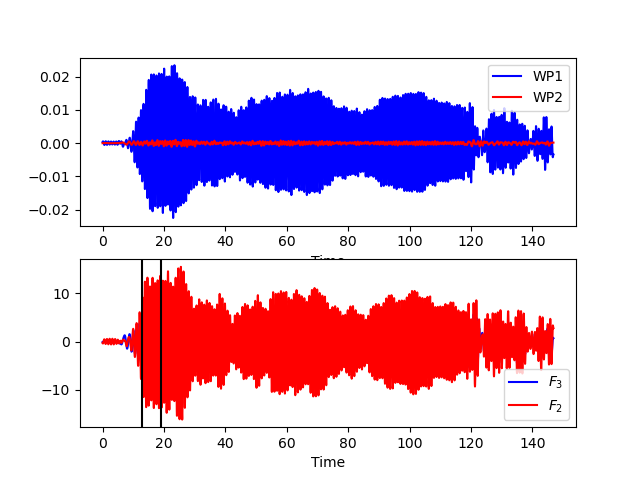

In [24]:
#%matplotlib widget

# Let us select a steady state time window by looking at the figure above
tstart = 13
tstop = 19


# Plot force-timeseries
fig4, ax4 = plt.subplots(2, 1)
ax4[0] = df2_filt.plot(ax=ax4[0], y='WP1', color='b', label=r'WP1')
ax4[0] = df2_filt.plot(ax=ax4[0], y='WP2', color='r', label=r'WP2')

ax4[1] = df2_filt.plot(ax=ax4[1], y='F3', color='b', label=r'$F_3$')
ax4[1] = df2_filt.plot(ax=ax4[1], y='F2', color='r', label=r'$F_2$')
ax4[1] = plt.axvline(tstart, color='k')
ax4[1] = plt.axvline(tstop, color='k')


In [25]:

#ax4[1].axvline(tstart, color='k') # add vertical line to indicate start time-window
#ax4[1].axvline(tstop, color='k') # add vertical line to indicate stop time-window

df2_steady = df2_filt.loc[tstart:tstop]

In [29]:
#locate zero upcrossings of measured heave (we then have two full cycles)
iups = np.ravel(np.argwhere(np.diff(np.sign(df2_steady['F3'].values)) > 0))
print(df2_steady.index[iups])

nPer = len(iups)-1 # Number of oscillation periods

# Wave period
Tp = np.mean(np.diff(df2_steady.index[iups]))
omg1 = 2*np.pi/Tp

# Input wave amplitude
A = 0.02

# Extract force amplitude
Fex3a = 0.5*(np.max(df2_steady['F3'].iloc[iups[0]:iups[1]])-np.min(df2_steady['F3'].iloc[iups[0]:iups[1]]))

print("Number of wave periods: {}".format(nPer))
print("Wave period: T={}".format(Tp))
print("Fex3a={:.3f}".format(Fex3a))

Float64Index([ 13.59500064572785, 14.425000685150735, 15.260000724811107,
              16.080000763759017, 16.935000804369338, 17.755000843317248,
               18.61000088392757],
             dtype='float64', name='Time')
Number of wave periods: 6
Wave period: T=0.8358333730332864
Fex3a=6.618


Estimate the Froude-Kriloff force on the ship section. The velocity potential for a regular wave on finite water depth according to linear wave theory is
$$\phi(x,z,t)=\frac{g\zeta_a}{\omega}\frac{\cosh(k(z+h))}{\cosh(kh)}\sin(kx-\omega t)$$
Implement your expression for the Froude-Kriloff force *amplitude* in the code-block below. You can neglect the rounded bilges in your calculations and consider the model as a box with sharp edges.

In [30]:
def computeFroudeKriloff(omega, k, A, h, B, d):
    '''
    Compute Froude-Kriloff force in heave.
    param [in] omega: [rad/s] Wave frequency
    param [in] k: [rad/m] Wave number
    param [in] A: [m] Wave amplitude
    param [in] h: [m] Water depth
    param [in] B: [m] Model beam
    param [in] d: [m] Model draft
    
    return F3fk_amp [N/m] Froude-Kriloff force amplitude in heave
    '''
    rho=1000.
    g = 9.81
    F3fk_amp = 2*rho*g*A*L/k*np.cosh(k*(-d+h))/np.cosh(k*h)*np.sin(k*B/2)

    return F3fk_amp

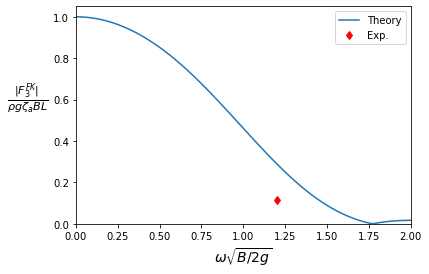

In [31]:
# Construct a nondimensional frequency array, spanning the same frequencies as the radiation problem.
omghat = np.linspace(0.001, 2, 100)
omgvec = omghat/np.sqrt(B/(2*g)) # [rad/s] wave frequency
omg1hat = omg1*np.sqrt(B/(2*g))

# Create array of wavenumbers for given wave frequencies and waterdepth in the wave tank
kvec = np.array([aw.findWaveNumber(omega_i, waterDepth=h) for omega_i in omgvec]) # Iterate over frequency array

Avec = np.ones_like(kvec) # Unit wave amplitudes

# Vertical Froude-Kriloff force amplitude (per unit length):
F3fk_amp = computeFroudeKriloff(omgvec, kvec, Avec, h, B, d)

# We don't need interactive plotting here...
%matplotlib inline 

# Plot results
fig3 = plt.figure()
plt.plot(omghat, np.abs(F3fk_amp)/(rho*g*B*L), label='Theory')
plt.plot(omg1hat, np.abs(Fex3a)/(rho*g*A*B*L), 'rd', label=r'Exp.')
plt.xlabel(r"$\omega\sqrt{B/2g}$", fontsize=14)
plt.ylabel(r"$\frac{|F_3^{FK}|}{\rho g\zeta_a BL}$", rotation=0, fontsize=16, labelpad=25)
plt.xlim(xmin=0, xmax=np.max(omghat))
plt.ylim(ymin=0)
plt.legend()

Look at the comparison above. What is the difference between the measured excitation force and the Froude-Kriloff force?